In [2]:
import datetime as dt
from __future__ import division

# data analysis imports
import pymysql as msql
import pandas as pd
import numpy as np

# vis imports
import matplotlib.pyplot as plt
import seaborn as sb

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

# CV
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import StratifiedShuffleSplit

# metrics
from sklearn.metrics import classification_report

import pdb

% matplotlib inline

In [ ]:
"""
Tables
------
cb_acquisitions
cb_degrees
cb_funding_rounds
cb_funds
cb_ipos
cb_milestones
cb_objects
cb_offices
cb_people
cb_relationships
cb_investments
"""

### Helper Methods

In [3]:
def establish_connection():
    """
        Helper to establish connection with local mysql database. Returns cursor object. Publicly available
        dataset so password commits are ignored.
    """
    conn = msql.connect(host="localhost", user="root", password="startupmi", db="startupmi", 
                        cursorclass=msql.cursors.DictCursor)
    return conn.cursor()

In [4]:
def fetch_dataframe(cursor):
    """
        Helper to fetch from database and return pandas dataframe.
        
        Parameters
        ----------
        cursor : {pymysql.connection.cursor}
            primary cursor obj
    """
    return pd.DataFrame(cursor.fetchall())

In [218]:
def classification(estimator, X, y, n_folds=10, name=""):
    """
        Helper to run classification with arbitrary estimator.
        
        Parameters
        ----------
        estimator : {sklearn.*}
            scikit learn estimator - e.g. RandomForestClassifier, GaussianNB
        
        X : {numpy.array}
            full feature set to be split into train/test
        
        y : {numpy.array}
            target set
        
        n_folds : {int}
            number of folds for stratified shuffle split
        
        name : {str}
            estimator name
    """
    if n_folds < 2:
        print "lower bound of 2 splits..."
        return None
    
    predicted = cross_val_predict(estimator, X, y, cv=n_folds, verbose=2)
    
    report_title = "Classification Report for %s With Cross Validation" % name
    matrix_title = "Confusion Matrix for %s With Cross Validation" % name
    
    print "\n"
    print report_title
    print "-"*len(report_title)
    print "\n"
    
    print classification_report(y, predicted)
    
    print "\n"
    print matrix_title
    print "-"*len(matrix_title)
    print "\n"
    
    print confusion_matrix(y, predicted)

In [225]:
def pn_separation(y_true, y_pred, class_labels):
    """
        Calculate true positives, true negatives, false positives, and false negatives.
        
        Parameters
        ----------
        y_true : {numpy.array}
            label test set
        
        y_pred : {numpy.array}
            predicted label set
        
        class_labels : {list}
            list of class labels as seen in test and predicted sets
    """
    cls_map = {}
    denom = len(y_true)
    for cls in class_labels:
        # define positive as labels belonging to the class of interest
        truthy = [val for idx, val in enumerate(y_true) if y_pred[idx] == val]
        tp = filter(lambda x: x == cls, truthy)
        tp = len(tp)
        tn = len(truthy) - tp
        falsy = [val for idx, val in enumerate(y_true) if y_pred[idx] != val]
        fp = filter(lambda x: x == cls, falsy)
        fp = len(fp)
        fn = len(falsy) - fp
        cls_map[cls] = {"tp": tp/denom, "fp": fp/denom, "tn": tn/denom, "fn":fn/denom}
    
    # average each value across all classes
    tp = np.average([cls_map[cls]["tp"] for cls in cls_map])
    tn = np.average([cls_map[cls]["tn"] for cls in cls_map])
    fp = np.average([cls_map[cls]["fp"] for cls in cls_map])
    fn = np.average([cls_map[cls]["fn"] for cls in cls_map])
    
    return ((tp, tn, fp, fn), cls_map)

In [250]:
def plot_corr(df, size_x=30, size_y=30):
    """
        Plot seaborn correlation matrix. Dataframe feature slice should be
        conducted prior to invoking this method.
        
        Parameters
        ----------
        df : {pandas.DataFrame}
            values for which correlation is built and plotted
    """
    fig, ax = plt.subplots(figsize=(size_x,size_y))
    corr = df.corr()
    # truncate correlation matrix
    for col in corr.columns:
        corr[col] = corr[col].apply(lambda x: "%.1f" % x)
        corr[col] = corr[col].apply(lambda x: float(x))
    # seaborn plot
    sb.heatmap(corr, annot=True, fmt="g", cmap="viridis")
    plt.show()

### Data Ingestion
Create dataframes for all of the db tables.

In [6]:
crs = establish_connection()

In [7]:
crs.execute("select * from cb_acquisitions")
df_acquisitions = fetch_dataframe(crs)

crs.execute("select * from cb_degrees")
df_degrees = fetch_dataframe(crs)

crs.execute("select * from cb_funding_rounds")
df_funrnds = fetch_dataframe(crs)

crs.execute("select * from cb_funds")
df_funds = fetch_dataframe(crs)

crs.execute("select * from cb_investments_1")
df_investments = fetch_dataframe(crs)

crs.execute("select * from cb_ipos")
df_ipos = fetch_dataframe(crs)

crs.execute("select * from cb_milestones")
df_milestones = fetch_dataframe(crs)

crs.execute("select * from cb_objects")
df_objects = fetch_dataframe(crs)

crs.execute("select * from cb_offices")
df_offices = fetch_dataframe(crs)

crs.execute("select * from cb_people")
df_people = fetch_dataframe(crs)

crs.execute("select * from cb_relationships")
df_relationships = fetch_dataframe(crs)

### Breaking Up Objects Table

In [ ]:
df_all_companies = df_objects.loc[df_objects['entity_type']=='Company']
df_closed_companies = df_all_companies.loc[df_all_companies['status']=='closed']

df_acquired_companies = df_all_companies.loc[df_all_companies['status']=='acquired']
df_ipo_companies = df_all_companies.loc[df_all_companies['status']=='ipo']

frames = [df_closed_companies, df_acquired_companies, df_ipo_companies]
df_relevant_companies = pd.concat(frames)

df_fin_orgs = df_objects.loc[df_objects['entity_type']=='FinancialOrg']
df_people = df_objects.loc[df_objects['entity_type']=='Person']

# don't use df_objects anymore, use one of the above

### Checking for table consistency

In [ ]:
# Check that df_acquired_companies matches up perfectly with df_acquisitions

df_acquired_tings = df_all_companies.loc[df_all_companies['id'].isin(df_acquisitions.acquired_object_id)]

# should be empty set
print np.setdiff1d(df_acquired_tings.id, df_acquired_companies.id)

# should also be empty but isn't for some reason..
# probably because those rows were deleted in Objects but not in Acquisitions
print np.setdiff1d(df_acquisitions.acquired_object_id, df_acquired_tings.id)
deleted_companies = np.setdiff1d(df_acquisitions.acquired_object_id, df_acquired_tings.id)

# should be all False
print np.in1d(deleted_companies, df_acquired_companies.id)

# so we can go ahead and delete these from df_acquisitions
acq_companies = np.setdiff1d(df_acquisitions.acquired_object_id, deleted_companies)
df_acquisitions = df_acquisitions[df_acquisitions.acquired_object_id.isin(acq_companies)]

# should be empty now--so we good
print np.setdiff1d(df_acquisitions.acquired_object_id, df_acquired_tings.id)

In [ ]:
# same checks for ipo companies
df_ipo_tings = df_all_companies.loc[df_all_companies['id'].isin(df_ipos.object_id.unique())]

# should be empty but is not
print np.setdiff1d(df_ipo_tings.id, df_ipo_companies.id)
# df_ipo_tings is bigger
print df_ipo_tings.shape, df_ipo_companies.shape
# this is because some companies that have been acquired have gone public
# under their own name (not their acquirers name)
# so we should prbly just take df_ipo_tings as our list of ipo_companies
df_ipo_companies = df_ipo_tings

### Transformations
Apply transformations to each of the transformations for dtype compatibility. Create additional dataframes where appropriate.

In [158]:
def acquisition_transform(df):
    """
        Method to transform acquisition dataframe for compatibility with remaining data set.
        
        Parameters
        ----------
        df : {pandas.DataFrame}
            acquisitons dataframe
    """
    # we trust master source (crunchbase) and we're not scraping source data
    # uninterested in creation/update dates
    drop_cols = ["source_url", "source_description", "created_at", "updated_at"]
    for col in drop_cols:
        df.drop(col, inplace=True, axis=1)
    
    # convert all decimal values to float for sklearn compatibility
    decimal_cols = ["price_amount"]
    for col in decimal_cols:
        df[col] = df[col].apply(lambda x: float(x) if x is not None else x)

In [160]:
acquisition_transform(df_acquisitions)

In [190]:
def degrees_transform(df, subject_ohe=False):
    """
        Method to transform degrees dataframe. All transformations are conducted on original dataframe.
        
        Parameters
        ----------
        df : {pandas.DataFrame}
            degrees dataframe
        
        subject_ohe : {bool}
            one hot encode subjects. default to False as degree subject might not necessarily be
            strong indicator of people success.
    """
    # uninterested in creation and update dates
    drop_cols = ["created_at", "updated_at"]
    for col in drop_cols:
        df.drop(col, inplace=True, axis=1)
    
    # significant date ranges for features
    
    df_degrees["subject"] = \
            df_degrees["subject"].apply(lambda x: [sub.strip() for sub in x.split(",")] if x is not None else [])
    
    if subject_ohe:
        # binary features for subjects (multiple subjects are grouped together)
        subject_store = set(sum(df_degrees.subject.tolist(), []))

        # OHE for each subject
        for subj in subject_store:
            df["is_%s" % subj] = df["subject"].apply(lambda x: 1 if subj in x else 0)

        df.drop("subject", inplace=True, axis=1)

In [ ]:
degrees_transform(df_degrees)

In [ ]:
def funds_transform(df):
    drop_cols = ["created_at", "updated_at", "source_description", "source_url"]
    for col in drop_cols:
        df.drop(col, inplace=True, axis=1)
    
    decimal_cols = ["raised_amount"]
    for col in decimal_cols:
        df[col] = df[col].apply(lambda x: float(x) if x is not None else x)

In [ ]:
funds_transform(df_funds)

### Feature Extraction

In [8]:
df_company = df_objects[(df_objects.status != "operating") & (df_objects.entity_type == "Company")]

In [12]:
# store names for future reference
name_index = df_company[["id", "normalized_name"]]
df_company.drop("normalized_name", inplace=True, axis=1)

/Users/siddhanthunnithan/.virtualenvs/document_classification/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [14]:
drop_cols = ["entity_type", "description", "first_milestone_at", "logo_url", "parent_id", "updated_at",
                 "created_at", "homepage_url", "investment_rounds", "last_milestone_at",
                 "logo_width", "permalink", "short_description", "closed_at", "created_by", "entity_id", "logo_height",
                 "twitter_username", "domain"]
df_company_mod = df_company.drop(drop_cols, axis=1)

In [15]:
df_company_mod.columns

Index([      u'category_code',                u'city',        u'country_code',
          u'first_funding_at', u'first_investment_at',          u'founded_at',
            u'funding_rounds',   u'funding_total_usd',                  u'id',
        u'invested_companies',     u'last_funding_at',  u'last_investment_at',
                u'milestones',            u'overview',              u'region',
             u'relationships',          u'state_code',              u'status',
                  u'tag_list'],
      dtype='object')

In [16]:
df_investments["investor_class"] = df_investments.investor_object_id.apply(lambda x: x.split(":")[0])

In [17]:
# map investor class to new col in company df
inv_class_map = {"c":"num_comp_investors", "f":"num_fin_investors", "p":"num_ppl_investors"}

for cls in inv_class_map:
    inter_count = pd.DataFrame(
        df_investments[df_investments.investor_class == cls].groupby("funded_object_id").count()["investor_object_id"]).reset_index()
    inter_count.columns = ["object_id", inv_class_map[cls]]
    df_company_mod = df_company_mod.merge(inter_count, left_on="id", right_on="object_id", how="left")
    df_company_mod.drop("object_id", inplace=True, axis=1)
    
    # assign 0 for companies with 0 count
    df_company_mod[inv_class_map[cls]] = df_company_mod[inv_class_map[cls]].apply(lambda x: 0 if np.isnan(x) else x)

df_company_mod["total_investors"] = \
    df_company_mod["num_comp_investors"] + df_company_mod["num_fin_investors"] + df_company_mod["num_ppl_investors"]

In [18]:
df_company_mod.head()

,category_code,city,country_code,first_funding_at,first_investment_at,founded_at,funding_rounds,funding_total_usd,id,invested_companies,...,overview,region,relationships,state_code,status,tag_list,num_ppl_investors,num_comp_investors,num_fin_investors,total_investors
0,games_video,Culver City,USA,None,None,None,NaN,None,c:10,NaN,...,Flektor is a rich-media mash-up platform that ...,Los Angeles,6,CA,acquired,"flektor, photo, video",0,0,0,0
1,games_video,San Mateo,USA,None,None,None,NaN,None,c:100,NaN,...,There.com is an online virtual world where any...,SF Bay,12,CA,acquired,"virtualworld, there, teens",0,0,0,0
2,web,Mountain View,USA,2008-02-26,None,2007-10-01,1,5000000,c:1001,NaN,...,[FriendFeed](http://www.friendfeed.com) aims t...,SF Bay,14,CA,acquired,"socialnetwork, newsfeed, socialnetworkaggregator",2,0,1,3
3,games_video,None,None,None,None,2008-08-22,NaN,None,c:10012,NaN,...,moviestring.com provides a place for user to c...,unknown,1,None,closed,"movies, micro-reviews, micro-blogging",0,0,0,0
4,mobile,Palo Alto,USA,2008-09-01,None,2008-03-01,1,None,c:10014,NaN,...,Mobclix (www.mobclix.com) is the industry's la...,SF Bay,9,CA,acquired,"techcrunch50, tc50, iphone, analytics, free-de...",0,1,0,1


In [19]:
# null values across all columns
nan_count = pd.DataFrame(df_company_mod.isnull().sum())
nan_count.columns = ["nan_count"]
nan_count = nan_count.T

In [20]:
nan_count

,category_code,city,country_code,first_funding_at,first_investment_at,founded_at,funding_rounds,funding_total_usd,id,invested_companies,...,overview,region,relationships,state_code,status,tag_list,num_ppl_investors,num_comp_investors,num_fin_investors,total_investors
nan_count,2991,3662,3256,8013,12775,5728,7940,8549,0,12774,...,1074,0,4658,6008,0,2394,0,0,0,0


In [21]:
def delta_cols(dt_1, dt_2):
    """
        Compute days delta for date/time columns.
    """
    if dt_1 is None or dt_2 is None:
        return np.nan
    return (dt_2 - dt_1).days

In [22]:
# temporal features
td_dt = dt.date.today()

df_company_mod["age"] = df_company_mod.apply(lambda x: delta_cols(x["founded_at"], td_dt), axis=1)

df_company_mod["delta_funding"] = df_company_mod.apply(lambda x: delta_cols(x["last_funding_at"], x["first_funding_at"]),axis=1)

# skip investments for now

In [23]:
# clean continuous cols
df_company_mod["funding_rounds"] = df_company_mod["funding_rounds"].apply(lambda x: 0 if np.isnan(x) else x)

df_company_mod["funding_total_usd"] = df_company_mod["funding_total_usd"].apply(lambda x: 0.0 if x is None else x)

df_company_mod["milestones"] = df_company_mod["milestones"].apply(lambda x: 0 if np.isnan(x) else x)

df_company_mod["invested_companies"] = df_company_mod["invested_companies"].apply(lambda x: 0 if np.isnan(x) else x)

In [24]:
df_company_mod["success"] = df_company_mod["status"].apply(lambda x: 1 if x == "acquired" or x == "ipo" else 0)

In [25]:
# feature - number of successes (ipo or acquisition) across all investors

inv_cls_map = {"f": "fin_inv_successes", "c": "comp_inv_successes", "p": "ppl_inv_successes"}

for cls, colnm in inv_cls_map.iteritems():
    # group by investor id and funded object id
    inv_cls_filt = df_investments[df_investments.investor_class == cls]

    inv_fnd_grp = inv_cls_filt.groupby(["investor_object_id", "funded_object_id"]).count()
    old_cols = inv_fnd_grp.columns
    inv_fnd_grp = inv_fnd_grp.reset_index()
    inv_fnd_grp.columns = ["investor_id", "object_id"] + [col for col in old_cols]
    inv_fnd_grp.drop(old_cols, axis=1, inplace=True)

    # label funded objects as successful
    inv_fnd_grp = inv_fnd_grp.merge(df_company_mod[["id","success"]], left_on="object_id", right_on="id", how="inner")

    # group by investor id and sum successes
    inv_fnd_grp = inv_fnd_grp.groupby("investor_id").sum()["success"].reset_index()
    inv_fnd_grp.columns = ["investor_id", "num_success"]

    # group investments by funded companies
    fnd_inv_grp = inv_cls_filt.groupby(["funded_object_id", "investor_object_id"]).count()
    old_cols = fnd_inv_grp.columns
    fnd_inv_grp = fnd_inv_grp.reset_index()
    fnd_inv_grp.columns = ["object_id", "investor_id"] + [col for col in old_cols]
    fnd_inv_grp.drop(old_cols, axis=1, inplace=True)

    # merge with investor-success group
    fnd_inv_grp = fnd_inv_grp.merge(inv_fnd_grp, on="investor_id", how="inner")

    # group by funded companies and sum
    fnd_inv_grp = fnd_inv_grp.groupby("object_id").sum()["num_success"].reset_index()
    fnd_inv_grp.columns = ["object_id", colnm]
    
    df_company_mod = df_company_mod.merge(fnd_inv_grp, left_on="id", right_on = "object_id", how="left")
    df_company_mod.drop("object_id", inplace=True, axis=1)

    # fill nan values
    df_company_mod[colnm] = df_company_mod[colnm].apply(lambda x: 0 if np.isnan(x) else x)
    
# compute total number of successes across all types of investors
df_company_mod["total_investor_successes"] = \
    df_company_mod["fin_inv_successes"] + df_company_mod["comp_inv_successes"] + df_company_mod["ppl_inv_successes"]

In [26]:
def encoding_helper(x):
    try:
        x.encode("utf-8")
    except:
        x = x.decode("latin-1")
        x = x.encode("utf-8")
    
    return x

df_company_mod["overview"] = df_company_mod["overview"].apply(lambda x: x if type(x) == str else "")
df_company_mod["overview"] = df_company_mod["overview"].apply(lambda x: encoding_helper(x))

In [24]:
# topic features from overview (no topic binning)
v = TfidfVectorizer(stop_words="english")
ov_x = v.fit_transform(df_company_mod["overview"])
ov_x = ov_x.toarray()
ov_feats = pd.DataFrame(ov_x, columns=v.get_feature_names())
ov_feats = ov_feats.reset_index()
df_comp_ov = df_company_mod.reset_index()
df_comp_ov = df_comp_ov.merge(ov_feats, on="index", how="inner")
df_comp_ov.drop("index", inplace=True, axis=1)

In [27]:
# board member labels
df_relationships["on_board"] = df_relationships["title"].apply(lambda x: "board" in x.lower())
df_board = df_relationships[df_relationships["on_board"]]
df_board = df_board.groupby(["relationship_object_id", "on_board"]).count()["person_object_id"]
df_board = df_board.reset_index()
df_board.drop("on_board",inplace=True,axis=1)
df_board.columns = ["object_id", "num_board_members"]

In [28]:
# board members
df_company_mod = df_company_mod.merge(df_board, left_on="id", right_on="object_id", how="left")
df_company_mod.drop("object_id", inplace=True, axis=1)

# large number of companies without recorded board members - 10630
# set num board members to 0
df_company_mod["num_board_members"] = df_company_mod["num_board_members"].apply(lambda x: 0 if np.isnan(x) else x)

In [32]:
fnrnds_obj_dt_join.head()

,index,object_id,funded_at,raised_amount
0,0,c:1,2005-10-01,5250000
1,1,c:1,2007-01-01,9500000
2,2,c:1,2008-05-19,25000000
3,3,c:1001,2008-02-26,5000000
4,4,c:10014,2008-09-01,0


In [33]:
# feature - raised money between funding rounds
fnrnds_obj_dt_grp = df_funrnds.sort(columns="funded_at")
fnrnds_obj_dt_grp = df_funrnds.groupby(["object_id", "funded_at"]).count()["id"]
fnrnds_obj_dt_grp = fnrnds_obj_dt_grp.reset_index()
fnrnds_obj_dt_grp.drop("id", inplace=True, axis=1)
fnrnds_obj_dt_join = fnrnds_obj_dt_grp.merge(
    df_funrnds[["object_id", "funded_at", "raised_amount"]], how="inner", on=["object_id", "funded_at"])
# impute values of 0 for funding rounds with no raised amounts
fnrnds_obj_dt_join["raised_amount"] = fnrnds_obj_dt_join["raised_amount"].apply(lambda x: 0 if x is None else x)

# create custom dictionary mapping company => [(date_1, ra_1), .., (date_n, ra_n)]
fnrnds_dct = {}
combined = map(lambda x: (x[1], x[3]), fnrnds_obj_dt_join.to_records())
for obj_id, amt in combined:
    if obj_id not in fnrnds_dct:
        fnrnds_dct[obj_id] = [float(amt)]
        continue
    fnrnds_dct[obj_id].append(float(amt))

# compute deltas
fnrnds_delta = {obj_id: np.average(np.diff(amts)) for obj_id, amts in fnrnds_dct.iteritems()}
fnrnds_delta = pd.DataFrame(zip(fnrnds_delta.keys(), fnrnds_delta.values()))
fnrnds_delta.columns = ["object_id", "avg_rsd_amt_diff"]

# single round - average is 0
fnrnds_delta.avg_rsd_amt_diff = fnrnds_delta.avg_rsd_amt_diff.apply(lambda x: 0 if np.isnan(x) else x)
df_company_mod = df_company_mod.merge(fnrnds_delta, left_on="id", right_on="object_id", how="left")

# feature represents 'growth' so companies with no funding have 0 'growth'
df_company_mod["avg_rsd_amt_diff"] = df_company_mod["avg_rsd_amt_diff"].apply(lambda x: 0 if np.isnan(x) else x)
df_company_mod.drop("object_id", inplace=True, axis=1)

/usr/local/Cellar/python/2.7.10_2/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [36]:
# feature - time between milestones (average time to achieve milestone)
# also want to compute time between founding and first milestone
mlstn_obj_dt_grp = df_milestones.sort(columns="milestone_at")
mlstn_obj_dt_grp = mlstn_obj_dt_grp.groupby(["object_id", "milestone_at"]).count()["id"]
mlstn_obj_dt_grp = mlstn_obj_dt_grp.reset_index()
mlstn_obj_dt_grp.drop("id", inplace=True, axis=1)

mlstn_dct = {}
for obj_id, dt in map(lambda x: (x[1], x[2]), mlstn_obj_dt_grp.to_records()):
    if obj_id not in mlstn_dct:
        mlstn_dct[obj_id] = [dt]
        continue
    mlstn_dct[obj_id].append(dt)

# compute average deltas
mlstn_delta = {obj_id: np.average(map(lambda x: x.days, np.diff(arr))) for obj_id, arr in mlstn_dct.iteritems()}
mlstn_delta = pd.DataFrame(zip(mlstn_delta.keys(), mlstn_delta.values()), columns=["object_id", "avg_mlstn_diff"])

# only one milestone - set to zero
mlstn_delta["avg_mlstn_diff"] = mlstn_delta["avg_mlstn_diff"].apply(lambda x: 0 if np.isnan(x) else x)
df_company_mod = df_company_mod.merge(mlstn_delta, left_on="id", right_on="object_id", how="left")

# zero milestone growth in place of null values
df_company_mod["avg_mlstn_diff"] = df_company_mod["avg_mlstn_diff"].apply(lambda x: 0 if np.isnan(x) else x)
df_company_mod.drop("object_id", inplace=True, axis=1)

In [ ]:
# feature - number of offices
obj_office_grp = df_offices.groupby(["object_id"]).count()["office_id"]
obj_office_grp = obj_office_grp.reset_index()
obj_office_grp.columns = ["object_id", "num_offices"]
df_company_mod = df_company_mod.merge(obj_office_grp, left_on="id", right_on="object_id", how="left")
df_company_mod.drop("object_id", inplace=True, axis=1)
df_company_mod["num_offices"] = df_company_mod["num_offices"].apply(lambda x: 0 if np.isnan(x) else x)

In [54]:
# clean up region column prior to encoding
df_company_mod["region"] = df_company_mod["region"].apply(lambda x: encoding_helper(x))
df_company_mod["region"] = df_company_mod["region"].apply(lambda x: x.decode("utf-8"))

In [65]:
# impute missing relationship values
df_company_mod["relationships"] = df_company_mod["relationships"].apply(lambda x: 0 if np.isnan(x) else x)

In [82]:
df_relationships.head(2)

,created_at,end_at,id,is_past,person_object_id,relationship_id,relationship_object_id,sequence,start_at,title,updated_at,on_board
0,2007-05-25 07:03:54,None,1,0,p:2,1,c:1,8,None,Co-Founder/CEO/Board of Directors,2013-06-03 09:58:46,True
1,2007-05-25 07:04:16,None,2,1,p:3,2,c:1,279242,None,VP Marketing,2010-05-21 16:31:34,False


In [83]:
# feature - company reach

df_relationships["person_cls"] = df_relationships["person_object_id"].apply(lambda x: x.split(":")[0])

df_relationships["obj_cls"] = df_relationships["relationship_object_id"].apply(lambda x: x.split(":")[0])

# group relationships by people - count companies
ppl_comp_cnt = df_relationships[(df_relationships["person_cls"] == "p") & (df_relationships["obj_cls"] == "c")]
ppl_comp_cnt = ppl_comp_cnt.groupby("person_object_id").count()["relationship_object_id"]
ppl_comp_cnt = ppl_comp_cnt.reset_index()
ppl_comp_cnt.columns = ["person_object_id", "company_count"]

# group relationships by companies and people
comp_ppl_grp = df_relationships[(df_relationships["person_cls"] == "p") & (df_relationships["obj_cls"] == "c")]
comp_ppl_grp = comp_ppl_grp.groupby(["relationship_object_id", "person_object_id"]).count()["id"]
comp_ppl_grp = comp_ppl_grp.reset_index()
comp_ppl_grp.columns = ["object_id", "person_object_id", "id"]
comp_ppl_grp.drop("id", inplace=True, axis=1)

# merge both groups
comp_ppl_grp = comp_ppl_grp.merge(ppl_comp_cnt, on="person_object_id", how="inner")

# aggregate company reach
comp_ppl_grp = comp_ppl_grp.groupby("object_id").sum()["company_count"]
comp_ppl_grp = comp_ppl_grp.reset_index()
comp_ppl_grp.columns = ["object_id", "company_reach"]
comp_ppl_grp["company_reach"] = comp_ppl_grp["company_reach"].apply(lambda x: 0 if np.isnan(x) else x)
df_company_mod = df_company_mod.merge(comp_ppl_grp, left_on="id", right_on="object_id", how="left")
df_company_mod.drop("object_id", inplace=True, axis=1)
df_company_mod["company_reach"] = df_company_mod["company_reach"].apply(lambda x: 0 if np.isnan(x) else x)

In [125]:
# feature - techcrunch mentions

df_tc = pd.read_csv("techcrunch_posts.csv")

# cleanup
df_tc["decoded_content"] = df_tc["content"].apply(lambda x: x if type(x) == str else "")
df_tc["decoded_content"] = df_tc["decoded_content"].apply(lambda x: x.decode("utf-8"))
df_tc = df_tc[["decoded_content", "category", "tags"]]

# stopword removal
df_tc["pos_content"] = df_tc["decoded_content"].apply(lambda x: x.split())
df_tc["pos_content"] = df_tc["pos_content"].apply(lambda x: set(x) - set(stopwords.words("english")))
df_tc["pos_content"] = df_tc["pos_content"].apply(lambda x: list(x))


# custom proper noun detection - check for upper case
df_tc["pos_content"] = df_tc["pos_content"].apply(lambda x: filter(lambda y: y.istitle() ,x))

# unique companies
comp_uniq = set(df_company["name"].tolist())

# check for company mentions
df_tc["comp_mentions"] = df_tc["pos_content"].apply(lambda x: set(x) & comp_uniq)
df_tc["comp_mentions"] = df_tc["comp_mentions"].apply(lambda x: list(x))

company_store = sum(df_tc["comp_mentions"].tolist(), [])
# build map count of companies
comp_cnt = {}
for comp in sum(df_tc["comp_mentions"].tolist(), []):
    if comp not in comp_cnt:
        comp_cnt[comp] = 1
        continue
    comp_cnt[comp] += 1
    
df_comp_cnt = pd.DataFrame(zip(comp_cnt.keys(), comp_cnt.values()), columns=["company_name", "tc_mentions"])

# convert company names to strings from unicode
df_comp_cnt["company_name"] = df_comp_cnt["company_name"].apply(lambda x: str(x))

# bring name back into company dataframe again - only executed because name was dropped earlier
df_company_mod = df_company_mod.merge(df_company[["id", "name"]], on="id", how="left")

# merge with count dataframe
df_company_mod = df_company_mod.merge(df_comp_cnt, left_on="name", right_on="company_name", how="left")
df_company_mod.drop("company_name", inplace=True, axis=1)
df_company_mod["tc_mentions"] = df_company_mod["tc_mentions"].apply(lambda x: 0 if np.isnan(x) else x)

In [96]:
# set target var
target_map = {class_var:idx for idx, class_var in enumerate(set(df_company_mod["status"].tolist()))}
df_company_mod["class"] = df_company_mod["status"].apply(lambda x: target_map[x])

In [210]:
# OHE categorical columns

# drop_cols = ["state_code", "region", "city"]
# df_company_mod.drop(drop_cols, inplace=True, axis=1)

categorical_cols = ["category_code", "country_code", "region"]
# df_company_mod["region"] = df_company_mod["region"].apply(lambda x: encoding_helper(x))
# df_company_mod["region"] = df_company_mod["region"].apply(lambda x: x.decode("utf-8"))
df_encode = pd.get_dummies(df_company_mod, columns=categorical_cols)

In [211]:
df_company_mod.columns

Index([           u'category_code',                     u'city',
                   u'country_code',         u'first_funding_at',
            u'first_investment_at',               u'founded_at',
                 u'funding_rounds',        u'funding_total_usd',
                             u'id',       u'invested_companies',
                u'last_funding_at',       u'last_investment_at',
                     u'milestones',                 u'overview',
                         u'region',            u'relationships',
                     u'state_code',                   u'status',
                       u'tag_list',        u'num_ppl_investors',
             u'num_comp_investors',        u'num_fin_investors',
                u'total_investors',                      u'age',
                  u'delta_funding',                  u'success',
              u'ppl_inv_successes',       u'comp_inv_successes',
              u'fin_inv_successes', u'total_investor_successes',
              u'num_board

In [209]:
omit_features = ["category_code", "city", "country_code", "first_funding_at", "first_investment_at", "founded_at", 
                 "id", "last_funding_at", "last_investment_at", "overview", "state_code",
                 "status", "tag_list", "success", "class", "name"]

# temporarily remove time-features due to volume of NaNs
omit_features.append("delta_funding") # 8013
omit_features.append("age") # 5728

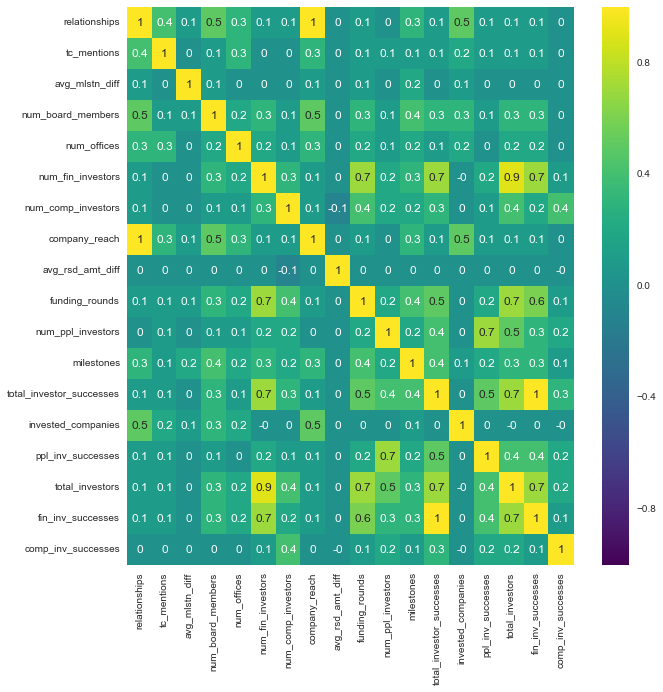

In [251]:
cont_fts = list(set(df_company_mod.columns) - set(omit_features))
cont_fts = [ft for ft in cont_fts if ft not in categorical_cols]
plot_corr(df_company_mod[cont_fts], size_x=10, size_y=10)

### Model Training

In [212]:
features = list(set(df_encode.columns) - set(omit_features))
X = df_encode[features].values
y = df_encode["class"].values
X_train = X[:int(len(X)*0.7)]
X_test = X[int(len(X)*0.7):]
y_train = y[:int(len(y)*0.7)]
y_test = y[int(len(y)*0.7):]

In [118]:
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score

In [213]:
# log reg
logreg = LogisticRegression(verbose=2)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
# need to revisit class sampling - imbalanced support values
print "\n"
print classification_report(y_test, y_pred)

# print roc_auc_score([y_test]*3, [y_pred]*3)

print confusion_matrix(y_test, y_pred)

[LibLinear]

             precision    recall  f1-score   support

          0       0.72      0.96      0.82      2832
          1       0.05      0.03      0.03       287
          2       0.00      0.00      0.00       815

avg / total       0.52      0.69      0.60      3934

[[2713  119    0]
 [ 278    8    1]
 [ 767   48    0]]


In [96]:
# log reg - cv
classification(logreg, X, y, name="Logistic Regression")

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

Classification Report for Logistic Regression With Cross Validation
-------------------------------------------------------------------


             precision    recall  f1-score   support

          0       0.73      0.98      0.84      9394
          1       0.34      0.16      0.22      1134
          2       0.00      0.00      0.00      2584

avg / total       0.56      0.72      0.62     13112



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.1min finished


In [233]:
# linear svm
lin_svc = LinearSVC(verbose=2)
lin_svc.fit(X_train, y_train)
y_pred = lin_svc.predict(X_test)
print "\n"
print classification_report(y_test, y_pred)

print "\n"

print confusion_matrix(y_test, y_pred)

print "\n"

print map(lambda x: x*100, pn_separation(y_test, y_pred, [0,1,2])[0])

[LibLinear]

             precision    recall  f1-score   support

          0       0.85      0.80      0.83      2832
          1       0.52      0.19      0.28       287
          2       0.47      0.67      0.55       815

avg / total       0.75      0.73      0.73      3934



[[2274   41  517]
 [ 142   54   91]
 [ 264    8  543]]


[24.326385358413827, 48.652770716827654, 9.0069479749195054, 18.013895949839011]


In [232]:
# random forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print classification_report(y_test, y_pred)

print confusion_matrix(y_test, y_pred)

print "\n"

print map(lambda x: x*100, pn_separation(y_test, y_pred, [0,1,2])[0])

             precision    recall  f1-score   support

          0       0.83      0.95      0.89      2832
          1       0.66      0.31      0.42       287
          2       0.81      0.55      0.66       815

avg / total       0.81      0.82      0.80      3934

[[2691   42   99]
 [ 191   89    7]
 [ 361    4  450]]


[27.368242670733771, 54.736485341467542, 5.9650906625995592, 11.930181325199118]


In [283]:
# random forest - cv
classification(rf, X, y, name="Random Forest")

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    6.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   15.0s finished



building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    6.3s



building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 8

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   15.4s finished
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    0.0s



building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    6.2s



building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 8

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   15.3s finished
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    0.0s



building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    5.5s



building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 8

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.5s finished
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    0.0s



building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    5.3s



building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 8

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.8s finished
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    0.0s



building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    5.4s



building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 8

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.0s finished
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    0.0s



building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    5.9s



building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 8

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.5s finished
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    0.0s



building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    6.2s



building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 8

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   15.4s finished
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    0.0s



building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    5.8s



building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 8

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.0s finished
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    0.0s



building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    5.7s



building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 8

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.1s finished
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.6min finished





Classification Report for Random Forest With Cross Validation
-------------------------------------------------------------


             precision    recall  f1-score   support

          0       0.82      0.94      0.88      9394
          1       0.64      0.31      0.42      1134
          2       0.74      0.53      0.61      2584

avg / total       0.79      0.80      0.78     13112



In [234]:
# naive bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
print "\n"
print classification_report(y_test, y_pred)

print "\n"

print confusion_matrix(y_test, y_pred)

print "\n"

print map(lambda x: x*100, pn_separation(y_test, y_pred, [0,1,2])[0])



             precision    recall  f1-score   support

          0       0.49      0.02      0.04      2832
          1       0.56      0.03      0.06       287
          2       0.21      0.97      0.34       815

avg / total       0.43      0.22      0.11      3934



[[  66    5 2761]
 [  44    9  234]
 [  26    2  787]]


[7.3038468056261641, 14.607693611252328, 26.029486527707167, 52.058973055414334]


In [98]:
# naive bayes - cv
classification(nb, X, y, name="Gaussian Naive Bayes")



Classification Report for Gaussian Naive Bayes With Cross Validation
--------------------------------------------------------------------


             precision    recall  f1-score   support

          0       0.72      1.00      0.84      9394
          1       0.62      0.06      0.11      1134
          2       0.00      0.00      0.00      2584

avg / total       0.57      0.72      0.61     13112



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.2min finished
